In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
# From utils.py
def read_data(f):
	with open(f) as inp:
		lines = inp.readlines()
	data = []
	for line in lines:
		line = line.strip().split()
		sentence = []
		for token in line:
			token = token.split('|')
			word = token[0]
			tag = token[1]
			sentence.append((word,tag))
		data.append(sentence)
	return data

In [3]:
# from utils.py
def convert_data_for_training(data):
	#for d in data:
	#	tokens = [t[0] for t in d]
	#	tags = [t[1] for t in d]
	return [([t[0] for t in d],[t[1] for t in d]) for d in data]

In [4]:
# from pytorch_tagging.py
TRAINING_FILE = "./irish.train"
training_data = convert_data_for_training(read_data(TRAINING_FILE))

In [5]:
VALIDATION_FILE = "./irish.dev"
validation_data = convert_data_for_training(read_data(VALIDATION_FILE))

In [6]:
# from pytorch_tagging.py 
def words_tags_indes(data):
	word_to_ix = {'UNK':0}
	ix_to_word = {0:'UNK'}
	tag_to_ix = {}
	ix_to_tag = {}
	for sent, tags in data:
		for word in sent:
			if word not in word_to_ix:
				word_to_ix[word] = len(word_to_ix)
				ix_to_word[word_to_ix[word]] = word
		for tag in tags:
			if tag not in tag_to_ix:
				tag_to_ix[tag] = len(tag_to_ix)
				ix_to_tag[tag_to_ix[tag]] = tag
	return word_to_ix,ix_to_word,ix_to_tag, tag_to_ix

In [7]:
word_to_ix,ix_to_word,ix_to_tag, tag_to_ix = words_tags_indes(training_data)

In [8]:
#pytorch_tagging.py
torch.manual_seed(42)
#Converts a sequence of words to a tensor of numerical values. 
def prepare_sequence(seq, to_ix):
	idxs = []
	for word in seq:
		if word in to_ix:
			idxs.append(to_ix[word])
		else:
			 idxs.append(to_ix['UNK'])
	return torch.tensor(idxs, dtype=torch.long)

In [9]:
#pytorch_tagging.py
class LSTMTagger(nn.Module):
	# Class that defines our model
	def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
		super(LSTMTagger, self).__init__()
		self.hidden_dim = hidden_dim

		self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

		# The LSTM takes word embeddings as inputs, and outputs hidden states
		# with dimensionality hidden_dim.
		self.lstm = nn.LSTM(embedding_dim, hidden_dim)

		# The linear layer that maps from hidden state space to tag space
		self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

	# This is the forward computation, which constructs the computation graph
	def forward(self, sentence):
		# Get the embeddings
		embeds = self.word_embeddings(sentence)
		# put them through the LSTM and get its output
		lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
		# pass that output through the linnear layer
		tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
		# convert the logits to a log probability distribution
		tag_scores = F.log_softmax(tag_space, dim=1)
		return tag_scores

In [10]:
#pytorch_tagging.py
# Hyperparameters
EMBEDDING_DIM = 32
HIDDEN_DIM = 32
# DROPOUT = ?
# LAYERS = ?

In [11]:
#pytorch_taggin.py
# Initialize the model
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
# Loss function to use
loss_function = nn.NLLLoss()
# Optimizer to use during training
optimizer = optim.SGD(model.parameters(), lr=0.1)


In [12]:
#pytorch_taggin.py
# Training loop
def train_model(model,n_epochs, patience, training_data, validation_data):
	patience_counter = 0
	min_loss = np.inf
	path = "./model_save_Early_stop.pth"
	avg_training_losses = []
	avg_valid_losses = []
	for epoch in range(n_epochs):  # normally you would NOT do 100 epochs, it is toy data
		print(f"Starting epoch {epoch}...")
		training_losses = []
		for sentence, tags in training_data:
			# Step 1. Remember that Pytorch accumulates gradients.
			# We need to clear them out before each instance
			model.zero_grad()

			# Step 2. Get our inputs ready for the network, that is, turn them into
			# Tensors of word indices.
			# Eventually I suggest you use the DataLoader modules
			# The batching can take place here
			sentence_in = prepare_sequence(sentence, word_to_ix)
			targets = prepare_sequence(tags, tag_to_ix)
			# Step 3. Run our forward pass.
			tag_scores = model(sentence_in)
	
			# Step 4. Compute the loss, gradients, and update the parameters by
			#  calling optimizer.step()
			loss = loss_function(tag_scores, targets)
			training_losses.append(loss.item())
			loss.backward()
			optimizer.step()
		avg_training_losses.append(np.average(training_losses))
		print(" Training Loss is ",avg_training_losses[epoch])
		valid_losses = []
		for validation_sentence, validation_tags in validation_data:
			validation_sentence_in = prepare_sequence(validation_sentence, word_to_ix)
			validation_targets = prepare_sequence(validation_tags, tag_to_ix)
			validation_tag_scores = model(validation_sentence_in)
			validation_loss = loss_function(validation_tag_scores, validation_targets)
			valid_losses.append(validation_loss.item())
		avg_valid_losses.append(np.average(valid_losses))
		print("validation loss is ",avg_valid_losses[epoch])
		if min_loss > avg_valid_losses[epoch]:
			patience_counter = 0
			min_loss = avg_valid_losses[epoch]
		else:
			patience_counter+=1
			if patience_counter == patience:
				print("Early Stopping to avoid overfitting")
				model_checkpoint = torch.load(path)
				model.load_state_dict(model_checkpoint['state_dict'])
				optimizer.load_state_dict(model_checkpoint['optimizer'])
				model_epoch = model_checkpoint['epoch']
				print("patience counter is ",patience_counter)
				print("loaded epoch is",model_epoch)
				break
		if patience_counter==0:
			print("Saving model here")
			model_state = {'epoch' : epoch,
						'state_dict' : model.state_dict(),
						'optimizer' : optimizer.state_dict(),
						}
			torch.save(model_state, path)
		print("Patience counter",patience_counter)
	return avg_training_losses, avg_valid_losses

In [13]:
avg_training_losses, avg_valid_losses = train_model(model,50, 8, training_data, validation_data)

Starting epoch 0...
 Training Loss is  1.565852379855811
validation loss is  1.1198798529060348
Saving model here
Patience counter 0
Starting epoch 1...
 Training Loss is  0.9787535238064274
validation loss is  0.912713336574529
Saving model here
Patience counter 0
Starting epoch 2...
 Training Loss is  0.8117375570088081
validation loss is  0.8184561677888333
Saving model here
Patience counter 0
Starting epoch 3...
 Training Loss is  0.7170460696294736
validation loss is  0.7679519505630311
Saving model here
Patience counter 0
Starting epoch 4...
 Training Loss is  0.6516013894792139
validation loss is  0.7368716613003393
Saving model here
Patience counter 0
Starting epoch 5...
 Training Loss is  0.6017951272972518
validation loss is  0.7140697244463897
Saving model here
Patience counter 0
Starting epoch 6...
 Training Loss is  0.5610748627933444
validation loss is  0.6970037990796922
Saving model here
Patience counter 0
Starting epoch 7...
 Training Loss is  0.5264538141665346
valida

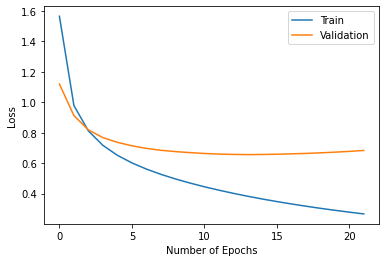

In [14]:
import matplotlib.pyplot as plt
plt.plot(avg_training_losses, label = 'Train')
plt.plot(avg_valid_losses, label = 'Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
# #pytorch_tagging.py
# # See what the scores are before training
# # Note that element i,j of the output is the score for tag j for word i.
# # Here we don't need to train, so the code is wrapped in torch.no_grad()
# with torch.no_grad():
#   #changes here
#   for index in range(len(training_data)):
#     #changes here
# 	  inputs = prepare_sequence(training_data[index][0], word_to_ix)
# 	  tag_scores = model(inputs)
# 	  print(tag_scores)
#    #changes here
# 	  for i,word in enumerate(training_data[index][0]):
# 		  j = int(np.argmax(tag_scores[i]))
# 		  print(f"\t{word}|{ix_to_tag[j]}")

In [16]:
TEST_FILE = "./irish.test"
test_data = convert_data_for_training(read_data(TEST_FILE))

with torch.no_grad():
	# this will be the file to write the outputs
	with open("mymodel_output_irish.txt", 'w') as op:
		for instance in test_data:
			# Convert the test sentence into a word ID tensor
			inputs = prepare_sequence(instance[0], word_to_ix)
			# Forward pass
			tag_scores = model(inputs)
			# Find the tag with the highest probability in each position
			outputs = [int(np.argmax(ts)) for ts in tag_scores]
			# Prepare the output to be written in the same format as the test file (word|tag)
			formatted_output = ' '.join([f"{word}|{ix_to_tag[tag_id]}" for word,tag_id in zip(instance[0],outputs)])
			# Write the output
			op.write(formatted_output + '\n')

In [17]:
#compute_accuracy
def acc_read_data(f):
	with open(f) as inp:
		lines = inp.readlines()
	data = []
	for line in lines:
		line = line.strip().split()
		sentence = []
		for token in line:
			token = token.split('|')
			word = token[0]
			tag = token[1]
			sentence.append((word,tag))
		data.append(sentence)
	return data

In [18]:
def compute_accuracy(output, gold):
	try:
		assert(len(output) == len(gold))
	except:
		print("Different number of lines in the two files!")
		return -1

	count_correct = 0
	count_total_tokens = 0
	for o_sent,g_sent in zip(output,gold):
		try:
			assert(len(o_sent)==len(g_sent))
		except:
			print("Different number of tokens in the two lines!")
			return -1
		check = [o_token[1] == g_token[1] for o_token,g_token in zip(o_sent,g_sent)]
		count_correct += sum(check)
		count_total_tokens += len(check)
	return count_correct/count_total_tokens

In [19]:
output = acc_read_data("./mymodel_output_irish.txt")
gold = acc_read_data("./irish.test")
acc = compute_accuracy(output,gold)

In [20]:
acc

0.8002769809081017